# Project 1

**Dataset:** Speed dating


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import scipy.stats as stats
import pandas as pd
from sympy import timed


In [2]:
np.random.seed(0)

In [3]:
import wandb

super_secret_API_key = "d1678741bcd8eb1d90ca26aa8f2bf079256ac391"

#wandb.login(key=super_secret_API_key)
# ak to chceme pouzivat, tak si tu budes musiet spravit ucet aby som ti mohol dat pristup
# https://wandb.ai/bizon-mimi-stu/ZNEUS_project1/workspace?nw=nwuserbizonmimi

In [4]:
# wandb test
import random
'''
# Start a new wandb run to track this script.
run = wandb.init(
    entity="bizon-mimi-stu",  # team name
    project="ZNEUS_project1",  # project name
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

# Simulate training.
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset

    # Log metrics to wandb.
    run.log({"acc": acc, "loss": loss})

# Finish the run and upload any remaining data.
run.finish()
'''
random.seed(0)

In [5]:
df_dating = pd.read_csv("DATA/.ipynb_checkpoints/speeddating-checkpoint.csv")
df_dating.head(10)

C:\Users\andre\AppData\Local\Temp\ipykernel_7816\2836534185.py:1: DtypeWarning: Columns (3,10,11,15,16,17,18,19,39,40,41,42,43,44,51,52,53,54,55,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,107,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dating = pd.read_csv("DATA/.ipynb_checkpoints/speeddating-checkpoint.csv")


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,0,0
1,0,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,5,[6-8],[5-6],1,1,0,0
2,1,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,...,[0-3],[3-5],7,?,[6-8],[0-4],1,1,1,1
3,0,1,female,21,23,2,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,1,1
4,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,...,[0-3],[3-5],6,6,[6-8],[5-6],0,1,1,1
5,0,1,female,21,25,4,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,5,[6-8],[5-6],0,0,1,0
6,0,1,female,21,30,9,[7-37],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,5,[6-8],[5-6],0,1,0,0
7,1,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,7,[6-8],[7-10],?,0,0,0
8,0,1,female,21,28,7,[7-37],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,7,[6-8],[7-10],0,1,1,1
9,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],6,6,[6-8],[5-6],0,1,0,0


In [6]:
df_dating.replace("?", np.nan, inplace=True)

In [7]:
df_dating.shape

(8378, 123)

In [8]:
df_dating.info

<bound method DataFrame.info of       has_null  wave  gender age age_o  d_age d_d_age  \
0            0     1  female  21    27      6   [4-6]   
1            0     1  female  21    22      1   [0-1]   
2            1     1  female  21    22      1   [0-1]   
3            0     1  female  21    23      2   [2-3]   
4            0     1  female  21    24      3   [2-3]   
...        ...   ...     ...  ..   ...    ...     ...   
8373         1    21    male  25    26      1   [0-1]   
8374         1    21    male  25    24      1   [0-1]   
8375         1    21    male  25    29      4   [4-6]   
8376         1    21    male  25    22      3   [2-3]   
8377         1    21    male  25    22      3   [2-3]   

                                         race  \
0     'Asian/Pacific Islander/Asian-American'   
1     'Asian/Pacific Islander/Asian-American'   
2     'Asian/Pacific Islander/Asian-American'   
3     'Asian/Pacific Islander/Asian-American'   
4     'Asian/Pacific Islander/Asian-Am

In [9]:
df_dating.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 123 columns):
 #    Column                           Dtype 
---   ------                           ----- 
 0    has_null                         int64 
 1    wave                             int64 
 2    gender                           object
 3    age                              object
 4    age_o                            object
 5    d_age                            int64 
 6    d_d_age                          object
 7    race                             object
 8    race_o                           object
 9    samerace                         int64 
 10   importance_same_race             object
 11   importance_same_religion         object
 12   d_importance_same_race           object
 13   d_importance_same_religion       object
 14   field                            object
 15   pref_o_attractive                object
 16   pref_o_sincere                   object
 17   pref_o_intel

In [10]:
missing_values = df_dating.isnull().sum().sort_values(ascending=False)

# Percentage of missing values
missing_percentage = (df_dating.isnull().mean() * 100).sort_values(ascending=False)

missing_df = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage": missing_percentage}
)

print(missing_df.head(50))

                               Missing Values  Percentage
expected_num_interested_in_me            6578   78.515159
expected_num_matches                     1173   14.000955
shared_interests_o                       1076   12.843161
shared_interests_partner                 1067   12.735736
ambitous_o                                722    8.617809
ambition_partner                          712    8.498448
met                                       375    4.476009
funny_o                                   360    4.296968
funny_partner                             350    4.177608
guess_prob_liked                          309    3.688231
intelligence_o                            306    3.652423
intelligence_partner                      296    3.533063
sinsere_o                                 287    3.425639
sincere_partner                           277    3.306278
like                                      240    2.864646
attractive_o                              212    2.530437
attractive_par

In [11]:
df_dating = df_dating.drop(columns="expected_num_interested_in_me")

In [12]:
duplicates = df_dating.duplicated().sum()

print(f"Number of duplicate rows: {duplicates}")


# df = df.drop_duplicates()

Number of duplicate rows: 0


In [13]:
df_dating.dtypes.value_counts()  # How many numeric, object, etc.

categorical = df_dating.select_dtypes(include=["object"]).columns
for col in categorical[:10]:  # Show first 10 to avoid spam
    print(f"{col}: {df_dating[col].nunique()} unique values")

gender: 2 unique values
age: 30 unique values
age_o: 24 unique values
d_d_age: 4 unique values
race: 5 unique values
race_o: 5 unique values
importance_same_race: 17 unique values
importance_same_religion: 15 unique values
d_importance_same_race: 3 unique values
d_importance_same_religion: 3 unique values


In [14]:
df_dating["d_pref_o_attractive"].unique()

array(['[21-100]', '[16-20]', '[0-15]'], dtype=object)

In [15]:
df_dating["d_d_age"].unique()

array(['[4-6]', '[0-1]', '[2-3]', '[7-37]'], dtype=object)

In [16]:
df_dating["d_importance_same_religion"].unique()

array(['[2-5]', '[0-1]', '[6-10]'], dtype=object)

použit precision metric ---


In [17]:
df_dating.describe()

,has_null,wave,d_age,samerace,decision,decision_o,match
count,8378.00000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000
mean,0.87491,11.350919,4.185605,0.395799,0.419909,0.419551,0.164717
std,0.33084,5.995903,4.596171,0.489051,0.493573,0.493515,0.370947
min,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.00000,11.000000,3.000000,0.000000,0.000000,0.000000,0.000000
75%,1.00000,15.000000,5.000000,1.000000,1.000000,1.000000,0.000000
max,1.00000,21.000000,37.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
from sklearn.preprocessing import LabelEncoder

# Get all columns that contain range strings
range_cols = [col for col in df_dating.columns if col.startswith("d_")]

other_categorical = ["gender", "race", "race_o"]

cols_to_encode = range_cols + other_categorical

le = LabelEncoder()

for col in cols_to_encode:
    if col in df_dating.columns:
        if df_dating[col].dtype in ["object", "string"]:
            most_frequent = df_dating[col].mode()[0]
            df_dating[col] = df_dating[col].fillna(most_frequent)

            df_dating[col] = le.fit_transform(df_dating[col])

print("Encoded columns sample:")
print(df_dating[cols_to_encode].head())
print("\nData types:")
print(df_dating[cols_to_encode].dtypes)
print("\nUnique values in d_d_age:", df_dating["d_d_age"].unique())

Encoded columns sample:
   d_age  d_d_age  d_importance_same_race  d_importance_same_religion  \
0      6        2                       1                           1   
1      1        0                       1                           1   
2      1        0                       1                           1   
3      2        1                       1                           1   
4      3        1                       1                           1   

   d_pref_o_attractive  d_pref_o_sincere  d_pref_o_intelligence  \
0                    2                 1                      1   
1                    2                 0                      0   
2                    1                 1                      1   
3                    2                 0                      0   
4                    2                 0                      1   

   d_pref_o_funny  d_pref_o_ambitious  d_pref_o_shared_interests  ...  d_yoga  \
0               1                   0                

In [19]:
print("Total NaN values:", df_dating.isna().sum().sum())

print("\nNaN count per column:")
print(df_dating.isna().sum())

print("\nColumns with NaN:")
print(df_dating.isna().sum()[df_dating.isna().sum() > 0])

print("\nPercentage of NaN per column:")
print((df_dating.isna().sum() / len(df_dating)) * 100)

Total NaN values: 11658

NaN count per column:
has_null                0
wave                    0
gender                  0
age                    95
age_o                 104
                     ... 
d_guess_prob_liked      0
met                   375
decision                0
decision_o              0
match                   0
Length: 122, dtype: int64

Columns with NaN:
age                                95
age_o                             104
importance_same_race               79
importance_same_religion           79
field                              63
pref_o_attractive                  89
pref_o_sincere                     89
pref_o_intelligence                89
pref_o_funny                       98
pref_o_ambitious                  107
pref_o_shared_interests           129
attractive_o                      212
sinsere_o                         287
intelligence_o                    306
funny_o                           360
ambitous_o                        722
shared_interes

In [20]:
from sklearn.impute import SimpleImputer

# Separate numeric and categorical
numeric_cols = df_dating.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = df_dating.select_dtypes(include=["object", "string"]).columns

# Impute numeric with median
imputer_num = SimpleImputer(strategy="median")
df_dating[numeric_cols] = imputer_num.fit_transform(df_dating[numeric_cols])

# Impute categorical with most frequent
imputer_cat = SimpleImputer(strategy="most_frequent")
if len(categorical_cols) > 0:
    df_dating[categorical_cols] = imputer_cat.fit_transform(df_dating[categorical_cols])


In [21]:
print("Total NaN values:", df_dating.isna().sum().sum())

print("\nNaN count per column:")
print(df_dating.isna().sum())

print("\nColumns with NaN:")
print(df_dating.isna().sum()[df_dating.isna().sum() > 0])

print("\nPercentage of NaN per column:")
print((df_dating.isna().sum() / len(df_dating)) * 100)

Total NaN values: 0

NaN count per column:
has_null              0
wave                  0
gender                0
age                   0
age_o                 0
                     ..
d_guess_prob_liked    0
met                   0
decision              0
decision_o            0
match                 0
Length: 122, dtype: int64

Columns with NaN:
Series([], dtype: int64)

Percentage of NaN per column:
has_null              0.0
wave                  0.0
gender                0.0
age                   0.0
age_o                 0.0
                     ... 
d_guess_prob_liked    0.0
met                   0.0
decision              0.0
decision_o            0.0
match                 0.0
Length: 122, dtype: float64


In [22]:
df_dating.head(20)

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0.0,1.0,0.0,21,27,6.0,2.0,0.0,3.0,0.0,...,0.0,1.0,7,6,1.0,1.0,0,1.0,0.0,0.0
1,0.0,1.0,0.0,21,22,1.0,0.0,0.0,3.0,0.0,...,0.0,1.0,7,5,1.0,1.0,1,1.0,0.0,0.0
2,1.0,1.0,0.0,21,22,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,7,5,1.0,0.0,1,1.0,1.0,1.0
3,0.0,1.0,0.0,21,23,2.0,1.0,0.0,3.0,0.0,...,0.0,1.0,7,6,1.0,1.0,0,1.0,1.0,1.0
4,0.0,1.0,0.0,21,24,3.0,1.0,0.0,2.0,0.0,...,0.0,1.0,6,6,1.0,1.0,0,1.0,1.0,1.0
5,0.0,1.0,0.0,21,25,4.0,2.0,0.0,3.0,0.0,...,0.0,1.0,6,5,1.0,1.0,0,0.0,1.0,0.0
6,0.0,1.0,0.0,21,30,9.0,3.0,0.0,3.0,0.0,...,0.0,1.0,6,5,1.0,1.0,0,1.0,0.0,0.0
7,1.0,1.0,0.0,21,27,6.0,2.0,0.0,3.0,0.0,...,0.0,1.0,6,7,1.0,2.0,0,0.0,0.0,0.0
8,0.0,1.0,0.0,21,28,7.0,3.0,0.0,3.0,0.0,...,0.0,1.0,7,7,1.0,2.0,0,1.0,1.0,1.0
9,0.0,1.0,0.0,21,24,3.0,1.0,0.0,3.0,0.0,...,0.0,1.0,6,6,1.0,1.0,0,1.0,0.0,0.0


In [23]:
df_dating["d_pref_o_attractive"].unique()

array([2., 1., 0.])

In [24]:
df_dating["d_d_age"].unique()

array([2., 0., 1., 3.])

In [25]:
df_dating["field"].unique()

array(['Law', 'law', 'Economics', "'Masters in Public Administration'",
       "'Masters of Social Work&Education'", 'Finance', 'Business',
       "'political science'", 'money', "'Operations Research'",
       "'TC [Health Ed]'", 'Psychology', "'social work'", "'Social Work'",
       "'Speech Language Pathology'", "'Speech Languahe Pathology'",
       "'Educational Psychology'", "'Applied Maths/Econs'", 'Mathematics',
       'Statistics', "'Organizational Psychology'",
       "'Mechanical Engineering'", 'Finanace', 'Finance&Economics',
       "'Undergrad - GS'", "'Mathematical Finance'", 'Medicine', 'MBA',
       'LAW', 'psychology', "'German Literature'",
       "'Business & International Affairs'", "'MFA Creative Writing'",
       'Engineering', "'Electrical Engineering'", 'Classics',
       "'Operations Research [SEAS]'", 'chemistry', 'Journalism',
       "'Elementary/Childhood Education [MA]'", 'microbiology',
       "'Masters of Social Work'", 'Communications', 'Marketing',
     

In [26]:
df_dating["d_importance_same_religion"].unique()

array([1., 0., 2.])

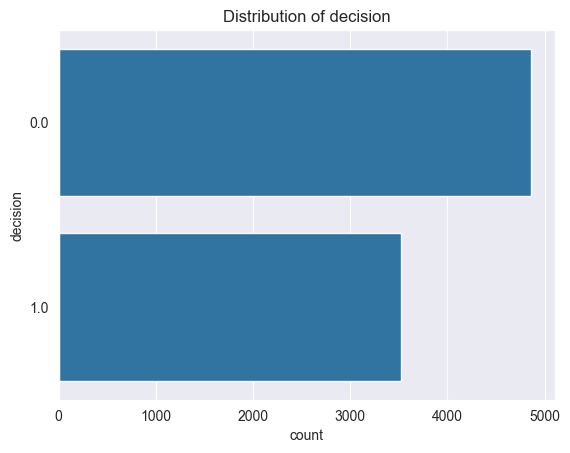

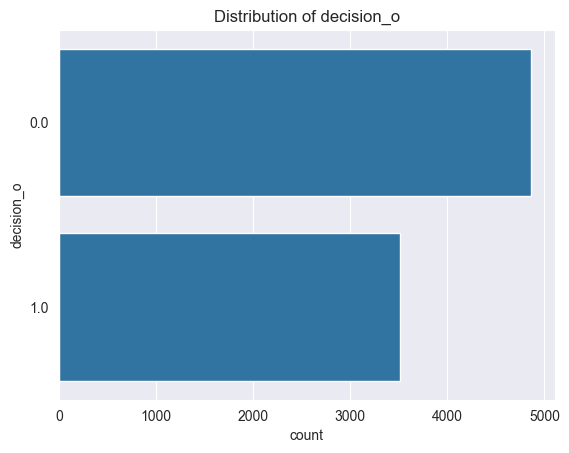

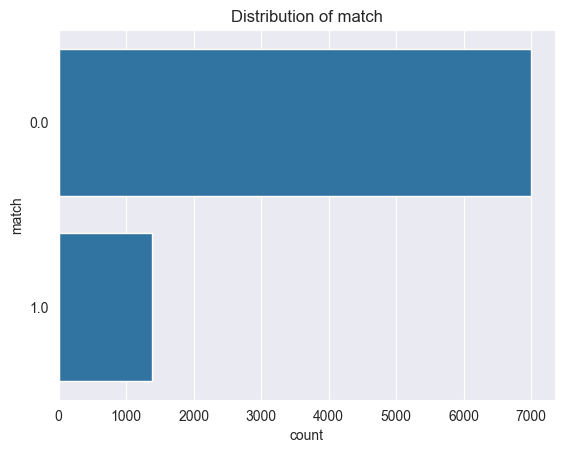

In [27]:
categorical = ['decision','decision_o', 'match']
for col in categorical:
    sns.countplot(y=col, data=df_dating)
    plt.title(f"Distribution of {col}")
    plt.show()

# Precision matrix?


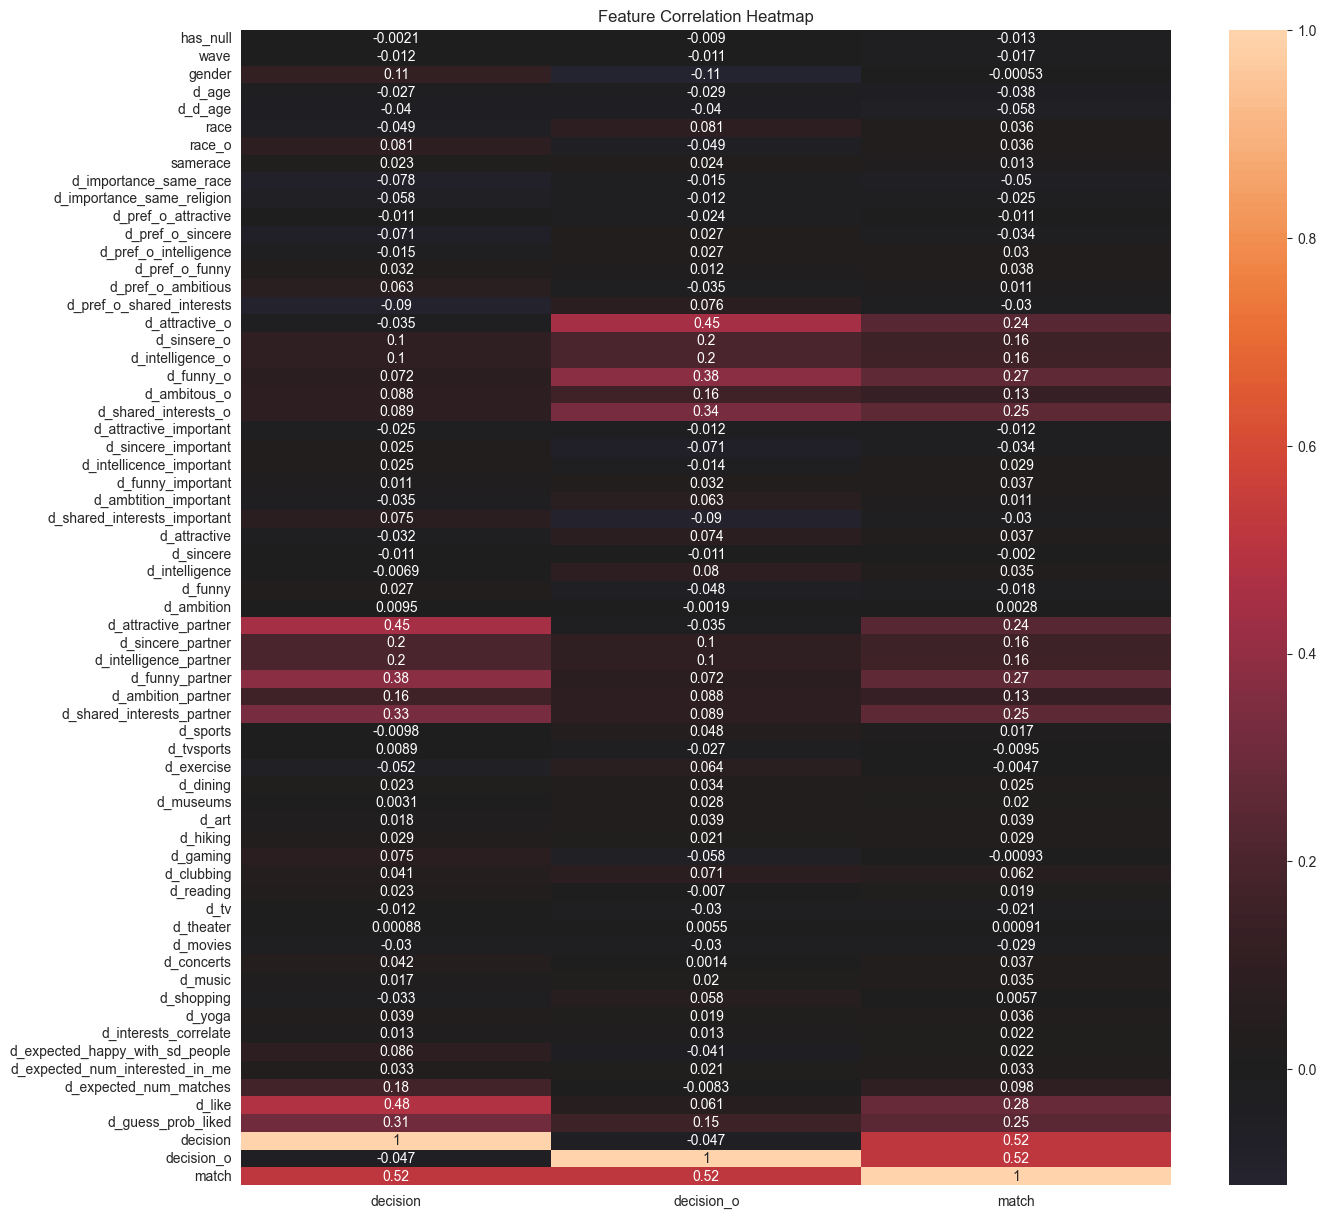

In [28]:
corr = df_dating.corr(numeric_only=True)

subset_corr = corr.loc[:, ['decision','decision_o', 'match']]

plt.figure(figsize=(15, 15))
sns.heatmap(subset_corr, center=0, annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

In [29]:
corr['decision'].sort_values(ascending=False).head(20)

decision                           1.000000
match                              0.521943
d_like                             0.482794
d_attractive_partner               0.452035
d_funny_partner                    0.375847
d_shared_interests_partner         0.334538
d_guess_prob_liked                 0.305509
d_sincere_partner                  0.202775
d_intelligence_partner             0.202662
d_expected_num_matches             0.177573
d_ambition_partner                 0.158678
gender                             0.110232
d_intelligence_o                   0.101195
d_sinsere_o                        0.100253
d_shared_interests_o               0.089353
d_ambitous_o                       0.087603
d_expected_happy_with_sd_people    0.085549
race_o                             0.080640
d_shared_interests_important       0.075493
d_gaming                           0.074709
Name: decision, dtype: float64

In [30]:
corr['decision_o'].sort_values(ascending=False).head(20)

decision_o                    1.000000
match                         0.522326
d_attractive_o                0.452818
d_funny_o                     0.376403
d_shared_interests_o          0.335046
d_sinsere_o                   0.203872
d_intelligence_o              0.203411
d_ambitous_o                  0.159231
d_guess_prob_liked            0.152864
d_intelligence_partner        0.100928
d_sincere_partner             0.099916
d_shared_interests_partner    0.089296
d_ambition_partner            0.087826
race                          0.080986
d_intelligence                0.079555
d_pref_o_shared_interests     0.075861
d_attractive                  0.074198
d_funny_partner               0.071757
d_clubbing                    0.070865
d_exercise                    0.064161
Name: decision_o, dtype: float64

In [31]:
corr['match'].sort_values(ascending=False).head(20)

match                         1.000000
decision_o                    0.522326
decision                      0.521943
d_like                        0.284972
d_funny_o                     0.266087
d_funny_partner               0.265523
d_shared_interests_o          0.252072
d_shared_interests_partner    0.251726
d_guess_prob_liked            0.246707
d_attractive_o                0.243062
d_attractive_partner          0.242534
d_intelligence_o              0.162352
d_intelligence_partner        0.161662
d_sinsere_o                   0.155709
d_sincere_partner             0.155004
d_ambitous_o                  0.133441
d_ambition_partner            0.133101
d_expected_num_matches        0.098002
d_clubbing                    0.062047
d_art                         0.038946
Name: match, dtype: float64

In [55]:
from sklearn.model_selection import train_test_split

predicting='decision'
X = df_dating[['d_attractive_partner', 'd_funny_partner','d_shared_interests_partner','d_sincere_partner','d_intelligence_partner','d_ambition_partner']].values

#predicting='decision_o'
#X = df_dating[['d_attractive_o', 'd_funny_o','d_shared_interests_o','d_sinsere_o','d_intelligence_o','d_ambitous_o']].values

#predicting='match'
#X = df_dating[['d_like', 'd_funny_o','d_funny_partner','d_shared_interests_o','d_shared_interests_partner','d_guess_prob_liked','d_attractive_o','d_attractive_partner']].values

#X = df_dating[['d_attractive_partner', 'd_funny_partner','d_shared_interests_partner','d_sincere_partner','d_intelligence_partner','d_ambition_partner', 'd_attractive_o', 'd_funny_o','d_shared_interests_o','d_sinsere_o','d_intelligence_o','d_ambitous_o']].values

y = df_dating[predicting].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)


In [56]:
from NN import train_model, evaluate_model

model, scaler = train_model(X_train, y_train, num_epochs=5000)
accuracy, predictions1 = evaluate_model(model, scaler, X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")
print("Predicted labels array:", predictions1)

Accuracy: 71.00%
Predicted labels array: [0. 0. 0. ... 0. 0. 1.]


In [58]:
predicting='decision_o'
X = df_dating[['d_attractive_o', 'd_funny_o','d_shared_interests_o','d_sinsere_o','d_intelligence_o','d_ambitous_o']].values

y = df_dating[predicting].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [59]:
model, scaler = train_model(X_train, y_train, num_epochs=5000)
accuracy, predictions2 = evaluate_model(model, scaler, X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")
print("Predicted labels array:", predictions2)

Accuracy: 68.50%
Predicted labels array: [1. 0. 1. ... 1. 0. 1.]


In [60]:
correct=0

for i in range(len(predictions1)):
    if predictions1[i] == 1 and predictions2[i] == 1:
        correct+=1
        
print(f"Correct: {correct}/{len(predictions1)} = {correct/len(predictions1)*100:.2f}%")

Correct: 535/1676 = 31.92%


In [63]:
predicting='match'
X = df_dating[['d_like', 'd_funny_o','d_funny_partner','d_shared_interests_o','d_shared_interests_partner','d_guess_prob_liked','d_attractive_o','d_attractive_partner']].values

#X = df_dating[['d_attractive_partner', 'd_funny_partner','d_shared_interests_partner','d_sincere_partner','d_intelligence_partner','d_ambition_partner', 'd_attractive_o', 'd_funny_o','d_shared_interests_o','d_sinsere_o','d_intelligence_o','d_ambitous_o']].values

y = df_dating[predicting].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
model, scaler = train_model(X_train, y_train, num_epochs=5000)
accuracy, predictions_match = evaluate_model(model, scaler, X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 74.64%
